In [1]:
%run "../head.py"

In [2]:
from hic_basic.mchr import Mchr
from hic_basic.plot.hic import _plot_mat

In [3]:
def plot_PM(mchr_path, region, title="TITLE", **kwargs):
    mchr = Mchr.from_netcdf(
        mchr_path
    )
    pm = mchr.PM(
                None,
                [region, region],
                proximity = 3
            )
    fig = _plot_mat(
        pm,
        title = title,
        donorm = False,
        ignore_diags = False,
        cmap = "Viridis",
        **kwargs
        )
    fig.update_layout(
        height = 800,
        width = 800
    )
    return fig
def plot_mean_scIS(df, title, range_y=[0.5, 1], strip_pos=False, norm_func=None):
    #print(df)
    if strip_pos:
        start, end = df.isna().diff().sum(axis=1).sort_values().index[-2:]
        #print(start, end)
        df = df.loc[start:end, :]
    data = df.mean(axis=1)
    if norm_func is not None:
        data = norm_func(data)
    x = data.index.get_level_values(1)
    y = data.values
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x = x,
            y = y,
            #mode = "lines+markers",
            mode = "lines",
            # marker = dict(
            #     size = 5,
            #     color = "black",
            # ),
            line = dict(
                width = 2,
                color = "black",
            ),
    )
    )
    fig.update_xaxes(
        title = "position",
    )
    fig.update_yaxes(
        title = "mean single-cell insulation score",
        range = range_y,
    )
    fig.update_layout(
        height = 400,
        width = 800,
        template = h.template,
        title = title
    )
    return fig
from pathlib import Path
def calc_and_plot_mean_scIS(mchr_path, region, cache, title, force=False, dip=False, norm_func=None, range_y=[0.5, 1], 
    strip_pos=False, give_df=False):
    mchr = Mchr.from_netcdf(
        mchr_path
    )
    if dip:
        chrom, other = region.split(":")
        chrom_mat = chrom + "(mat)"
        region_mat = ":".join([chrom_mat, other])
        cache_file = cache + "_mat.parquet"
        if not force and Path(cache_file).exists():
            IS_df_mat = pd.read_parquet(cache_file)
        else:
            IS_df_mat = mchr.IS(None, [region_mat, region_mat], w=10)
            IS_df_mat.to_parquet(cache_file)
        chrom_pat = chrom + "(pat)"
        region_pat = ":".join([chrom_pat, other])
        cache_file = cache + "_pat.parquet"
        if not force and Path(cache_file).exists():
            IS_df_pat = pd.read_parquet(cache_file)
        else:
            IS_df_pat = mchr.IS(None, [region_pat, region_pat], w=10)
            IS_df_pat.to_parquet(cache_file)
        IS_values = np.concatenate([IS_df_mat.values, IS_df_pat.values],axis=1)
        IS_df = pd.DataFrame(
            IS_values,
            index = pd.MultiIndex.from_product(
                [[chrom], IS_df_mat.index.get_level_values(1)]
            ),
        )
    else:
        cache_file = cache + ".parquet"
        if not force and Path(cache_file).exists():
            IS_df = pd.read_parquet(cache_file)
        else:
            IS_df = mchr.IS(None, [region, region], w=10)
            IS_df.to_parquet(cache_file)
    fig = plot_mean_scIS(IS_df, title, norm_func=norm_func, range_y=range_y, strip_pos=strip_pos)
    if give_df:
        return fig, IS_df
    else:
        return fig

In [4]:
force = False

### plot mouse IS

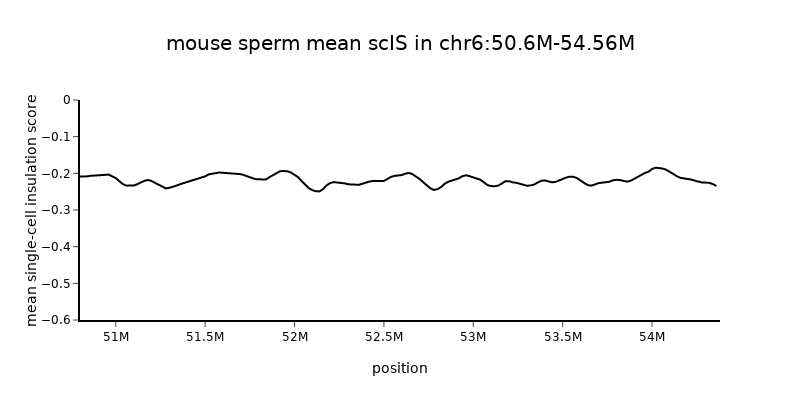

In [5]:
mchr_path = h.ddir / "Sperm.mchr.20k" / "3dg.nc"
region = "chr6:50,600,000-54,560,000"
cache = "Sperm_IS_df"
title = "mouse sperm mean scIS in chr6:50.6M-54.56M"
dip = False
#norm_func = None
#range_y=[0.7,0.95]
norm_func = np.log2
range_y=[-0.6,0]

fig, dm_IS = calc_and_plot_mean_scIS(mchr_path, region, cache, title, force, dip, norm_func=norm_func, range_y=range_y,
    strip_pos=True, give_df=True)
fig.show(renderer="png")
fig.write_image("output/mouse_sperm_mean_scIS.pdf")

In [6]:
meanIS = dm_IS.mean(axis=1)

In [7]:
IS = pd.read_table(
    h.ddir / "Sperm.20k.IS.tsv"
)
picked = IS.query('(chrom=="chr6") and (start > 50600000) and (end < 54560000)')
picked = picked[picked["is_boundary_200000"]]
picked = picked.query('boundary_strength_200000 >= 0.5')
data = pd.merge(
    picked,
    norm_func(meanIS.rename("meanIS")) if norm_func is not None else meanIS.rename("meanIS"),
    left_on = ["chrom", "start"],
    right_index = True,
    how = "left"
)

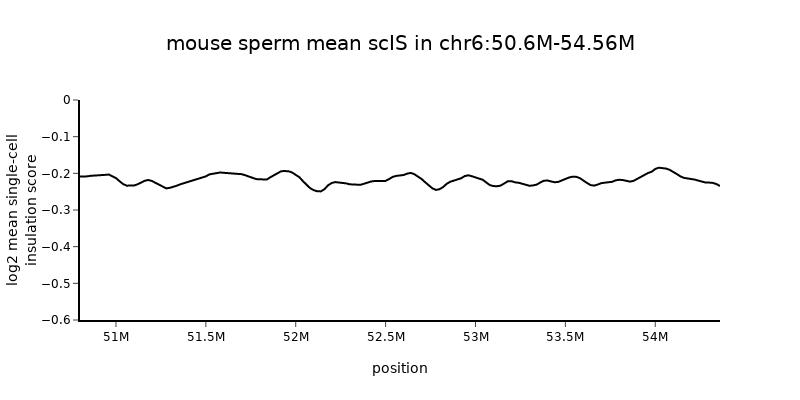

In [8]:
# add open-circle
fig.add_trace(
    go.Scatter(
        x = data["start"],
        y = data["meanIS"],
        mode = "markers",
        marker = dict(
            size = 10,
            color = "black",
            symbol = "circle-open",
        ),
    )
)
fig.update_layout(
    showlegend = False,
    yaxis = dict(
        title = "log2 mean single-cell<br>insulation score"
    ),
    xaxis = dict(
        #range = [data["start"].min(), data["end"].max()],
        range = [50800000, 54360000],
    )
)
fig.show(renderer="png")
fig.write_image("output/mouse_sperm_mean_scIS_border.pdf")

Tidying up distance matrix...


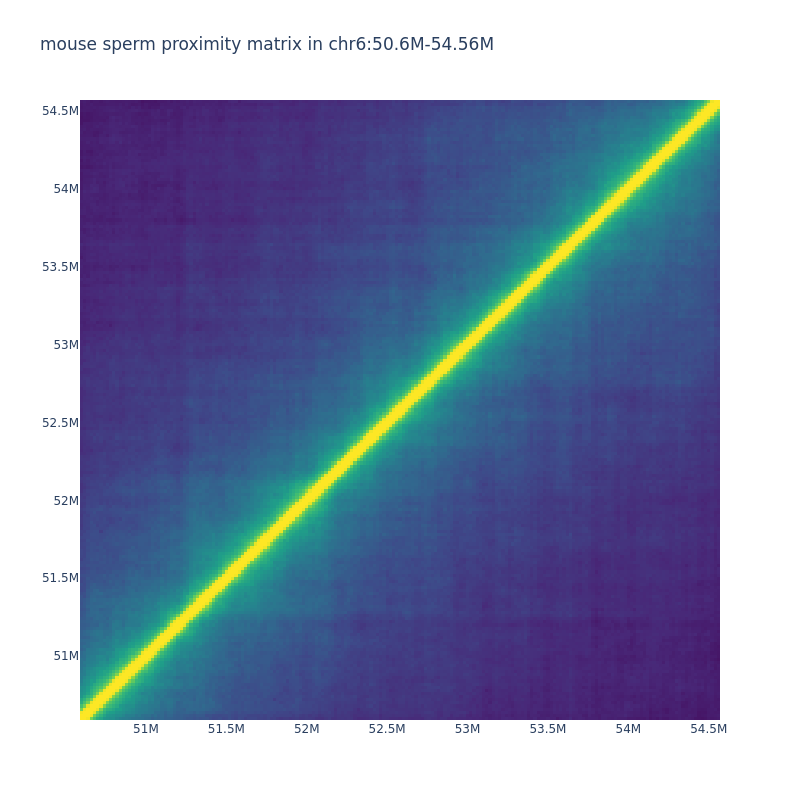

In [9]:
fig = plot_PM(
    mchr_path,
    title = "mouse sperm proximity matrix in chr6:50.6M-54.56M",
    region = "chr6:50,600,000-54,560,000",
    zmax = 1,
    zmin = 0
)
fig.show(renderer="png")

In [10]:
from hic_basic.TAD.IS import find_peak_prominence
def plot_peak_counts_proms(IS_df, batch="BATCH", region="REGION"):
    peak_counts, proms = [], []
    for sample in IS_df.columns:
        peak_index, peak_prom = find_peak_prominence(-IS_df.loc[:,sample])
        peak_counts.append(len(peak_index))
        proms.extend(peak_prom)
    peak_counts = np.array(peak_counts)
    proms = np.array(proms)

    # --- plot peak counts --- #
    range_x = [0, 30]
    x = peak_counts
    x = x[x>range_x[0]]
    x = x[x<range_x[1]]
    fig1 = px.histogram(
        x = x,
        histnorm = "probability density",
        nbins = 15,
        range_x = range_x,
        title = f"number of IS valleys in {batch} samples<br>{region}",
        labels = {"x": "number of peaks"},
        template = h.template,
    )
    # --- plot prominences --- #
    range_x = [-5, 0.2]
    x = np.log10(proms)
    x = x[x>range_x[0]]
    x = x[x<range_x[1]]
    fig2 = px.histogram(
        x = x,
        nbins = 40,
        range_x = range_x,
        histnorm = "probability density",
        title = f"prominence of valleys in {batch} samples<br>{region}",
        labels = {"x": "log10(prominence)"},
        template = h.template,
    )
    for fig in [fig1, fig2]:
        fig.update_traces(
            marker_color = px.colors.qualitative.G10[9],
            marker_line_color="black",
            marker_line_width = 1
        )
    fig1.update_layout(
        xaxis = dict(
            #range = [0, 30],
            ticks = "outside",
            tickvals = [0, 10, 20, 30],
        ),
        yaxis = dict(
            range = [0, 0.2]
        )
    )
    fig2.update_layout(
        yaxis = dict(
            range = [0, 1]
        ),
        xaxis = dict(
            #range = [-5, 0.2],
            ticks = "outside",
            tickvals = [-5, -4, -3, -2, -1, 0],
        )
    )
    return fig1, fig2

In [11]:
IS_df = pd.read_parquet(
    "Sperm_IS_df.parquet"
)
fig1, fig2 = plot_peak_counts_proms(
    IS_df,
    batch="mouse sperm",
    region = "chr6:50.6M-54.56M"
    )

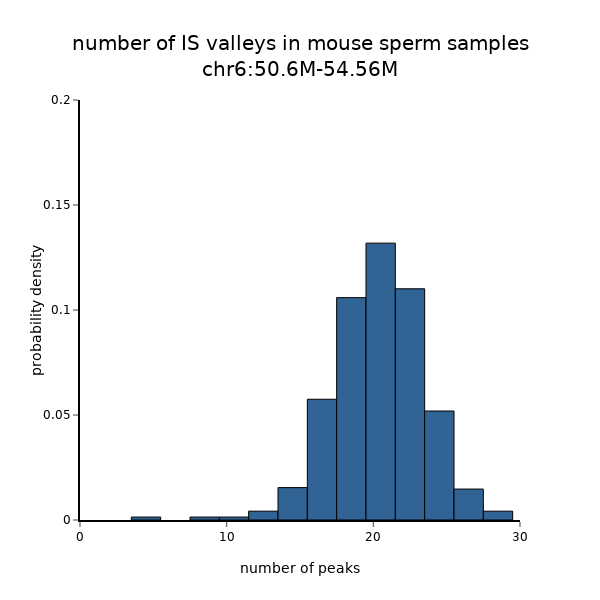

In [12]:
fig1.show(renderer="png")
fig1.write_image("output/mouse_sperm_peak_counts.pdf")

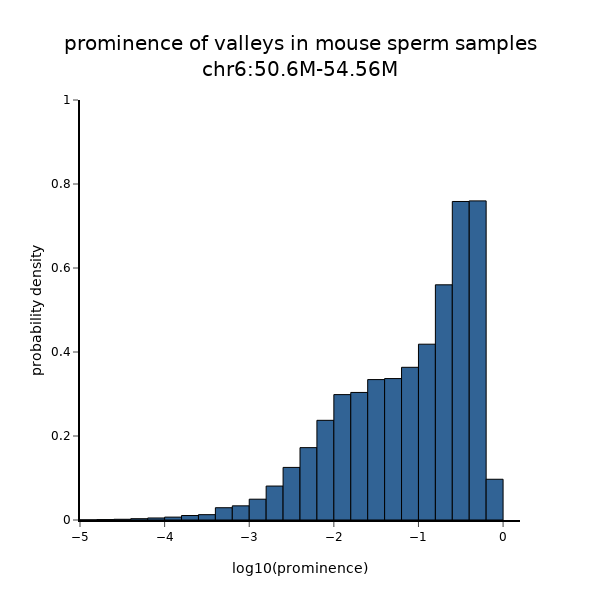

In [13]:
fig2.show(renderer="png")
fig2.write_image("output/mouse_sperm_peak_proms.pdf")

### plot mESC IS

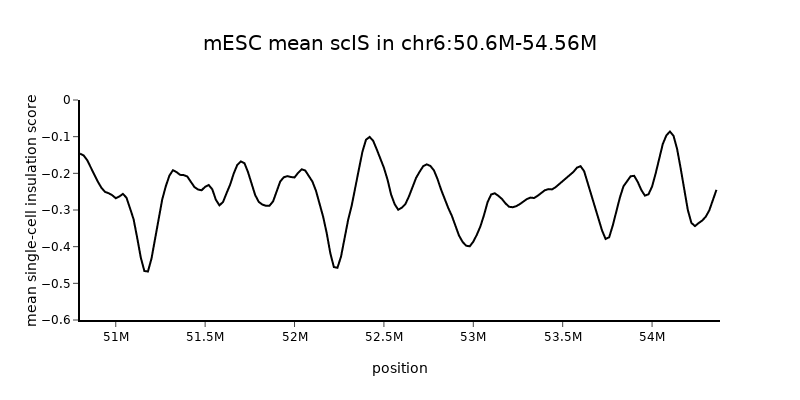

In [27]:
mchr_path = h.ddir / "mESC.mchr.20k" / "3dg.nc"
region = "chr6:50,600,000-54,560,000"
cache = "mESC_IS_df"
title = "mESC mean scIS in chr6:50.6M-54.56M"
dip = True
#norm_func = None
#range_y = [0.7,0.95]
norm_func = np.log2
range_y = [-0.6, 0]

fig, df = calc_and_plot_mean_scIS(mchr_path, region, cache, title, force, dip, norm_func=norm_func, range_y=range_y, 
    strip_pos=True, give_df=True)
fig.show(renderer="png")
fig.write_image("output/mESC_mean_scIS.pdf")

In [28]:
# ref_borders = pd.read_table(
#     "/share/Data/ychi/raw/Bonev2017/4DN.boundary.bed.gz",
#     names = ["chrom","start","end","border_type","score"]
# )
# picked = ref_borders.query('(chrom=="chr6") and (start > 50600000) and (end < 54560000)')
# strong = picked.query('border_type == "Strong"')

# binsize = 20000

# df = picked
# df = df.assign(
#     new_start = df["start"] // binsize * binsize,
# )
# df = df.groupby("new_start").size()

In [29]:
meanIS = df.mean(axis=1)

In [30]:
# IS = pd.read_table(
#     h.ddir / "mESC_allmerge.20k.IS.tsv"
# )
IS = pd.read_table(
    h.ddir / "mESC_allmerge.20k.IS.tsv"
)
picked = IS.query('(chrom=="chr6") and (start > 50600000) and (end < 54560000)')
picked = picked[picked["is_boundary_200000"]]
picked = picked.query('boundary_strength_200000 >= 0.5')
data = pd.merge(
    picked,
    norm_func(meanIS.rename("meanIS")) if norm_func is not None else meanIS.rename("meanIS"),
    left_on = ["chrom", "start"],
    right_index = True,
    how = "left"
)

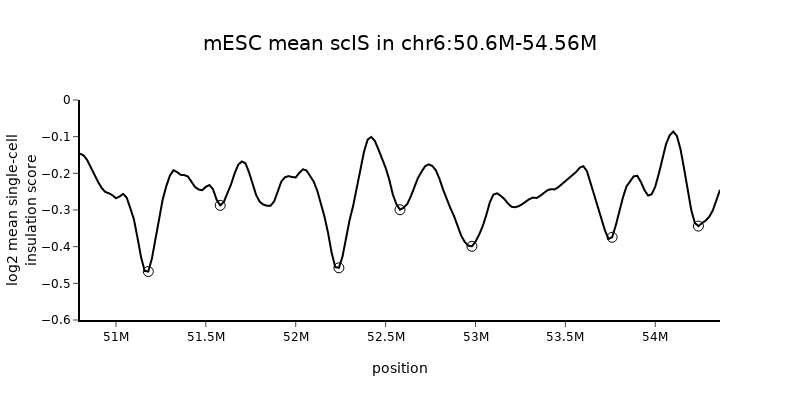

In [31]:
# add open-circle
fig.add_trace(
    go.Scatter(
        x = data["start"],
        y = data["meanIS"],
        mode = "markers",
        marker = dict(
            size = 10,
            color = "black",
            symbol = "circle-open",
        ),
    )
)
fig.update_layout(
    showlegend = False,
    yaxis = dict(
        title = "log2 mean single-cell<br>insulation score",
    ),
    xaxis = dict(
        range = [50800000, 54360000],
    )
)
fig.show(renderer="png")
fig.write_image("output/mESC_mean_scIS_border.pdf")

Tidying up distance matrix...


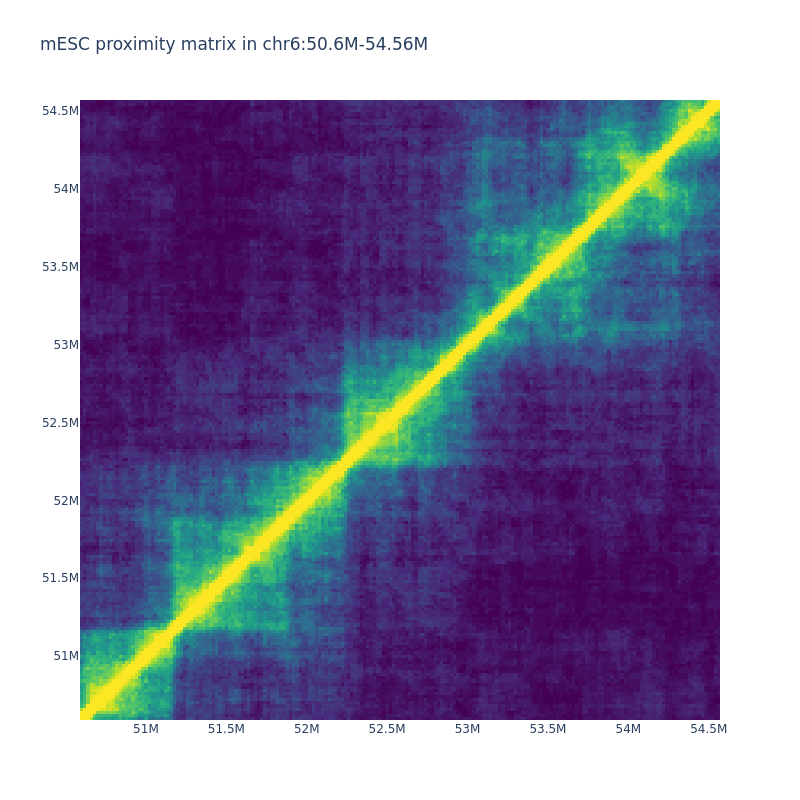

In [19]:
fig = plot_PM(
    mchr_path,
    title = "mESC proximity matrix in chr6:50.6M-54.56M",
    region = "chr6(mat):50,600,000-54,560,000",
    zmax = 1,
    zmin = 0
)
fig.show(renderer="png")

In [20]:
IS_df_mat = pd.read_parquet(
    "mESC_IS_df_mat.parquet"
)
IS_df_mat = IS_df_mat.reset_index(drop=True)
IS_df_pat = pd.read_parquet(
    "mESC_IS_df_pat.parquet"
)
IS_df_pat = IS_df_pat.reset_index(drop=True)
IS_df = pd.concat([IS_df_mat, IS_df_pat], axis=1)
IS_df.columns = [i for i in range(IS_df.shape[1])]
fig1, fig2 = plot_peak_counts_proms(
    IS_df,
    batch="mESC",
    region = "chr6:50.6M-54.56M"
    )

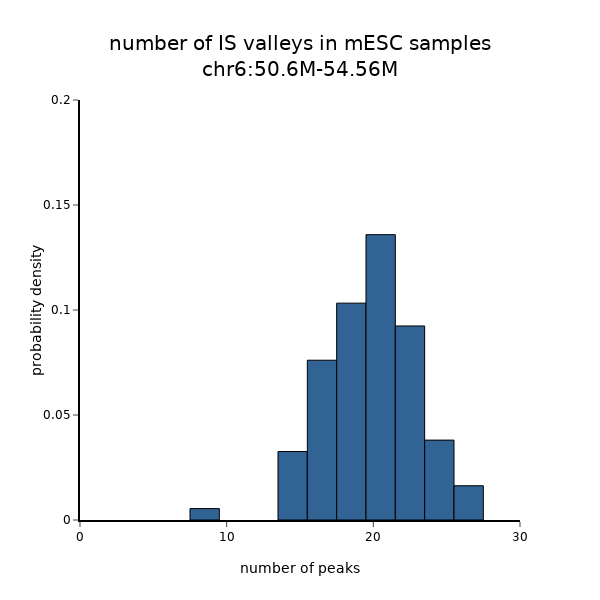

In [21]:
fig1.show(renderer="png")
fig1.write_image("output/mESC_peak_counts.pdf")

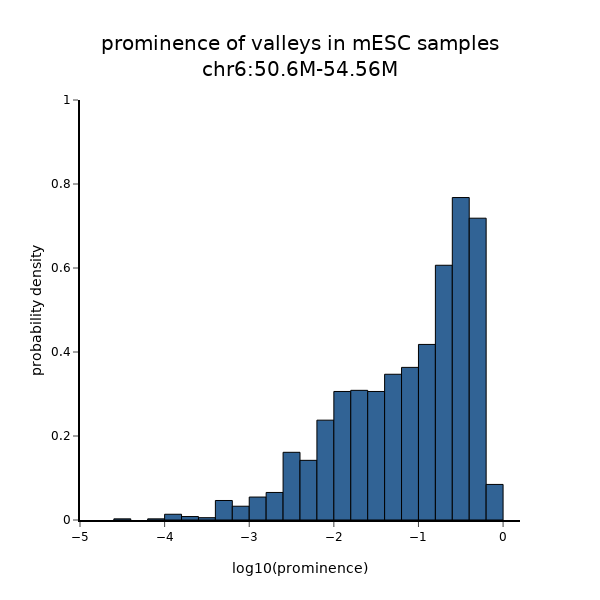

In [22]:
fig2.show(renderer="png")
fig2.write_image("output/mESC_peak_proms.pdf")

### do stat test

In [ ]:
def fetch_counts_proms(IS_df,  region="REGION"):
    peak_counts, proms = [], []
    for sample in IS_df.columns:
        peak_index, peak_prom = find_peak_prominence(-IS_df.loc[:,sample])
        peak_counts.append(len(peak_index))
        proms.extend(peak_prom)
    peak_counts = np.array(peak_counts)
    proms = np.array(proms)
    return peak_counts, proms
# add mouse sperm
dats = {}
IS_df = pd.read_parquet(
    "Sperm_IS_df.parquet",
)
peak_counts, proms = fetch_counts_proms(
    IS_df,
    region = "chr6:50.6M-54.56M"
    )
dats["mouse sperm"] = {
    "peak_counts": peak_counts,
    "proms": proms
}
# add mESC
IS_df_mat = pd.read_parquet(
    "mESC_IS_df_mat.parquet"
)
IS_df_mat = IS_df_mat.reset_index(drop=True)
IS_df_pat = pd.read_parquet(
    "mESC_IS_df_pat.parquet"
)
IS_df_pat = IS_df_pat.reset_index(drop=True)
IS_df = pd.concat([IS_df_mat, IS_df_pat], axis=1)
IS_df.columns = [i for i in range(IS_df.shape[1])]
peak_counts, proms = fetch_counts_proms(
    IS_df,
    region = "chr6:50.6M-54.56M"
    )
dats["mESC"] = {
    "peak_counts": peak_counts,
    "proms": proms
}

In [ ]:
from scipy.stats import mannwhitneyu
# show peak counts test
v, p = mannwhitneyu(
    dats["mESC"]["peak_counts"],
    dats["mouse sperm"]["peak_counts"]
)
print(f"peak counts: {p}")
# show prominences test, 2 digits
v, p = mannwhitneyu(
    dats["mESC"]["proms"],
    dats["mouse sperm"]["proms"]
)
print(f"prominences: {p}")

peak counts: 0.1987254919403989
prominences: 0.5751757565315709


### plot Sperm_hg IS

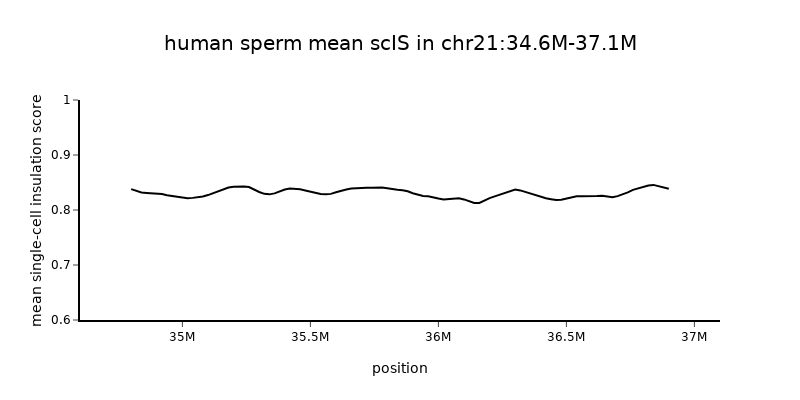

In [23]:
mchr_path = h.ddir / "Sperm_hg.mchr.20k" / "3dg.nc"
region = "chr21:34,600,000-37,100,000"
cache = "Sperm_hg_IS_df"
title = "human sperm mean scIS in chr21:34.6M-37.1M"
dip = False

fig = calc_and_plot_mean_scIS(mchr_path, region, cache, title, force, dip, range_y=[0.6,1])
fig.show(renderer="png")

### plot GM12878 IS

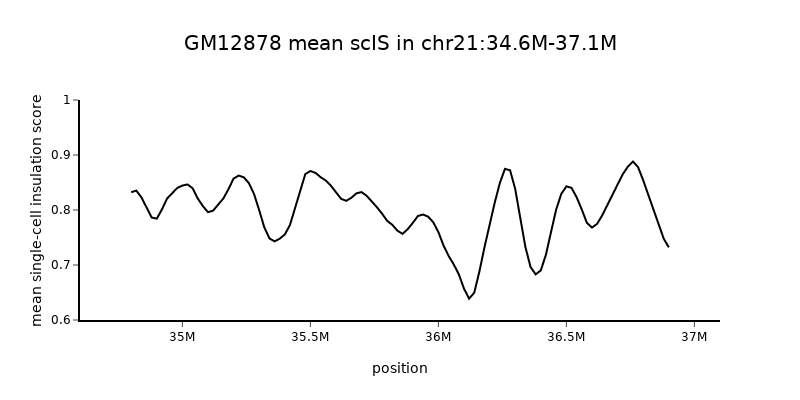

In [24]:
mchr_path = h.ddir / "Tan2018.mchr.20k" / "3dg.nc"
region = "chr21:34,600,000-37,100,000"
cache = "Tan2018_IS_df"
title = "GM12878 mean scIS in chr21:34.6M-37.1M"
dip = True

fig = calc_and_plot_mean_scIS(mchr_path, region, cache, title, force, dip, range_y=[0.6,1])
fig.show(renderer="png")